# Convolution and Pool Layers

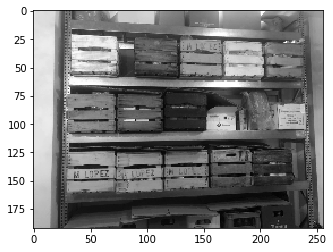

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

bgr_img = cv2.imread('imgs/shelf.JPG')
bgr_img = cv2.resize(bgr_img, (0,0), fx=0.25, fy=0.25) 
gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY).astype("float32")/255

plt.imshow(gray_img, cmap='gray')
plt.show()

## Convolution Layer

Suppose that out image looks like that
![Image](imgs/image_cl.png)
and filter
![Image](imgs/filter_cl.png)
Then applying filter means
![Applaying Filters](imgs/applying_cl.gif)

### Filters

In [60]:
import numpy as np

filter_1 = np.array([[-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1]])
filter_2 = np.array([[-1, -1, -1, -1], [-1, -1, -1, -1], [1, 1, 1, 1], [1, 1, 1, 1]])
filter_3 = np.array([[0, -1, 0, 0], [-1, 21, -1, 0], [0, -1, 0, 0], [0, 0, 0, 0]])
filter_4 = np.ones((4, 4))
filter_5 = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]) # Sobel
filter_6 = np.array([[0.5,0,0.5],[0,-2,0],[0.5,0,0.5]])
filters = np.array([filter_1, filter_2, filter_3, filter_4])

adv_filters = np.array([filter_5,filter_6])

filters,adv_filters

(array([[[-1., -1.,  1.,  1.],
         [-1., -1.,  1.,  1.],
         [-1., -1.,  1.,  1.],
         [-1., -1.,  1.,  1.]],
 
        [[-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.]],
 
        [[ 0., -1.,  0.,  0.],
         [-1., 21., -1.,  0.],
         [ 0., -1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]],
 
        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.]]]), array([[[ 1. ,  2. ,  1. ],
         [ 0. ,  0. ,  0. ],
         [-1. , -2. , -1. ]],
 
        [[ 0.5,  0. ,  0.5],
         [ 0. , -2. ,  0. ],
         [ 0.5,  0. ,  0.5]]]))

### Change shape for expexted by pytorch

In [49]:
filters_torch = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
filters_params = torch.nn.Parameter(filters_torch)
filters_params.shape

torch.Size([4, 1, 4, 4])

In [63]:
filters_torch = torch.from_numpy(adv_filters).unsqueeze(1).type(torch.FloatTensor)
filters_params_adv = torch.nn.Parameter(filters_torch)
filters_params_adv.shape

torch.Size([2, 1, 3, 3])

Shape of filters in pytorch

`[ number of output chanels, number of input chanels, hight, width]` 

### Change shape of image as well

In [62]:
gray_img_torch = torch.from_numpy(gray_img).unsqueeze(0).unsqueeze(1)
gray_img.shape, gray_img_torch.shape

((192, 256), torch.Size([1, 1, 192, 256]))

`[number of samples, number of input chanels, hight, width]`

### Model: we will expain it later

Here it is just to show how filters works!

In [65]:
class Net(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size):
        super(Net, self).__init__()        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, bias=False) # Kernel size = filter's size
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        conv_x = self.conv(x)
        activated_x = F.relu(conv_x)
        pool_x = self.pool(activated_x)
        
        return conv_x, activated_x, pool_x

## Initialize model
model = Net(1, 4, (4, 4))
## Initialize weights
model.conv.weight = filters_params

## Initialize Sobel model
adv_model = Net(1,2,(3, 3))
## Init Weights
adv_model.conv.weight = filters_params_adv

# print out the layer in the network
print(model)
print(adv_model)

Net(
  (conv): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Net(
  (conv): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


### Let's look at output of layers

##### Convolution layer

In [66]:
conv_layer, activated_layer, pooled_layer = model(gray_img_torch)
conv_layer.shape, activated_layer.shape

(torch.Size([1, 4, 189, 253]), torch.Size([1, 4, 189, 253]))

In [71]:
conv_layer_adv, activated_layer_adv, pooled_layer_adv = adv_model(gray_img_torch)
conv_layer_adv.shape, activated_layer_adv.shape

(torch.Size([1, 2, 190, 254]), torch.Size([1, 2, 190, 254]))

In [68]:
def viz_layer(layer):
    n_filters = layer.shape[1]
    fig = plt.figure(figsize=(20, 20))
    
    for i in range(n_filters):
        ax = fig.add_subplot(1, n_filters, i+1, xticks=[], yticks=[])
        # grab layer outputs
        ax.imshow(np.squeeze(layer[0,i].data.numpy()), cmap='gray')
        ax.set_title('Output %s' % str(i+1))

#### Output before activation

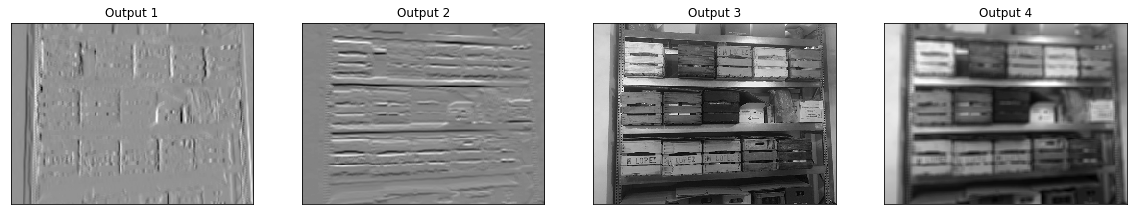

In [69]:
viz_layer(conv_layer)

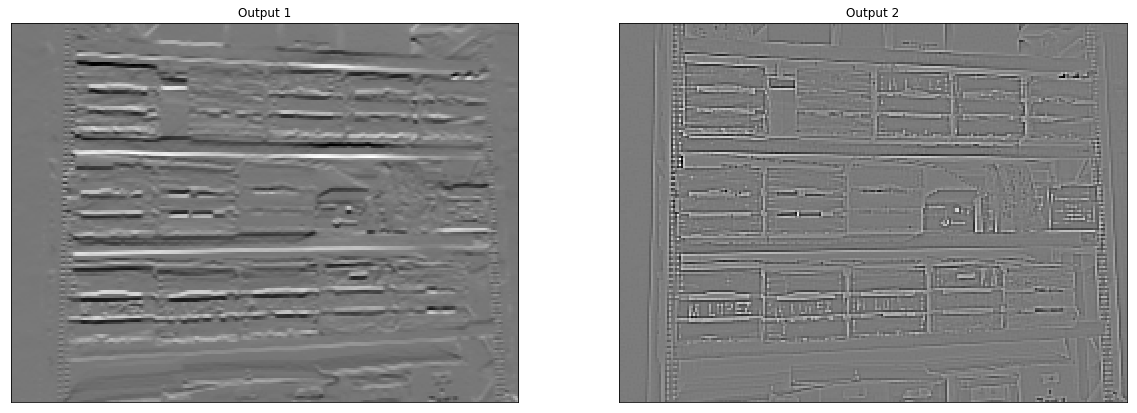

In [72]:
viz_layer(conv_layer_adv)

#### Output after activation

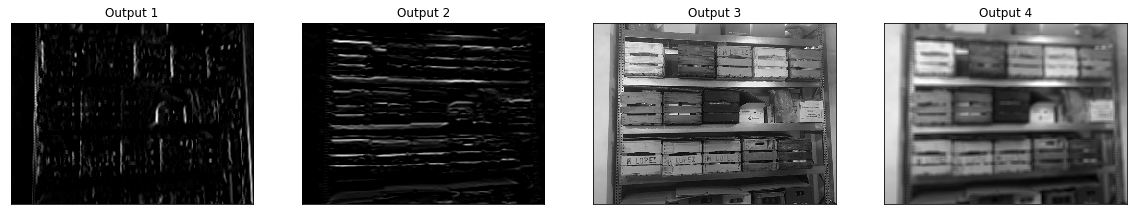

In [9]:
viz_layer(activated_layer)

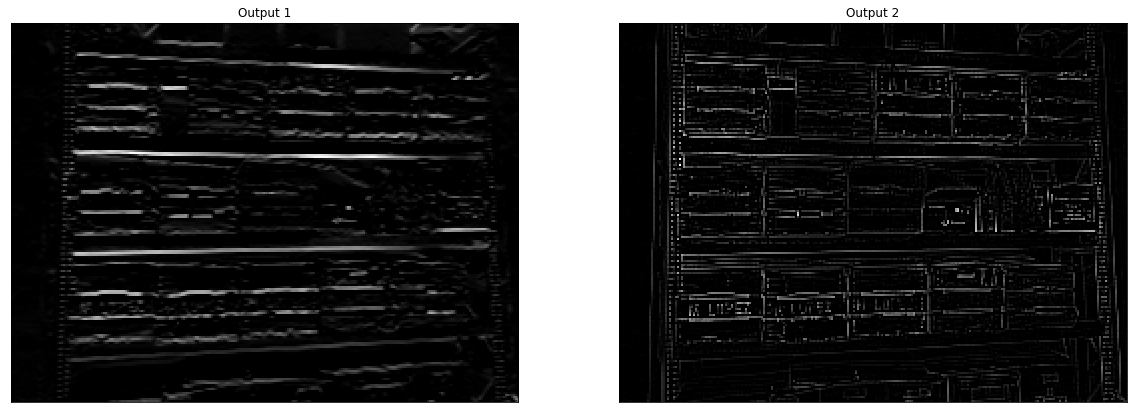

In [73]:
viz_layer(activated_layer_adv)

### MaxPool Layer

![Pooling](imgs/pool.jpeg)

![Pooling](imgs/maxpool.jpeg)

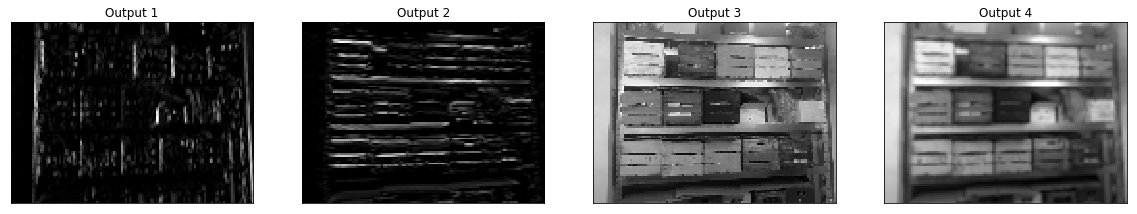

In [10]:
viz_layer(pooled_layer)

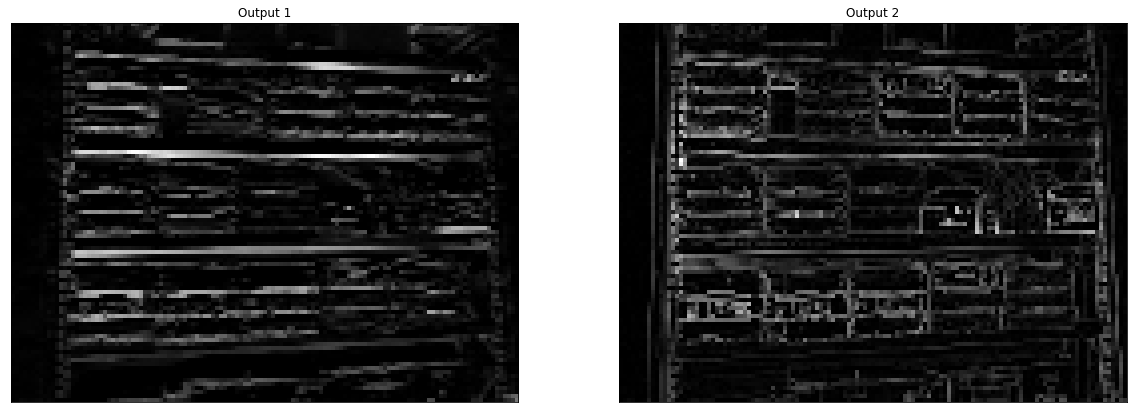

In [74]:
viz_layer(pooled_layer_adv)

In [8]:
print("Before: ", activated_layer.shape)
print("After: ", pooled_layer.shape)

Before:  torch.Size([1, 4, 189, 253])
After:  torch.Size([1, 4, 94, 126])


Links
* <https://adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/>
* <http://cs231n.github.io/convolutional-networks/>
* <http://udacity.com>